# Frontier Model Analysis

Analysis of relationship-seeking behavior across frontier language models.

## Setup

In [1]:
library(jsonlite)
library(httr)
library(dplyr)
library(tidyr)
library(ggplot2)
library(lubridate)
library(lme4)
library(lmerTest)
library(broom)
library(broom.mixed)
library(parameters)

# Set seed
set.seed(1234)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step




In [2]:
# Define publication-ready theme
theme_pub <- function() {
    theme(
        axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 20, face = "bold"),
        legend.text = element_text(size = 18, colour = "grey50"),
        # legend.title = element_text(size = 14, face = "bold"),
        legend.title = element_blank(),
        plot.subtitle = element_text(size = 14, colour = "grey50"),
        strip.text = element_text(size = 18, face = "bold"),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        # axis.line.x = element_line(colour = "black"),
        axis.line.y = element_line(colour = "black"),
        legend.position = "bottom",
        plot.margin = margin(10, 10, 10, 10)
    )
}


## Load Data and Fit Models

Loading scored results from ../data/scored_model_responses.jsonl...
Loaded 9865 scored records
Fetching model information from OpenRouter API...
Total observations: 9278
Unique models: 95
Unique prompts: 100
Unique providers: 23
Scores per model: 97.7 on average

LOADING VECTOR STEERING RESULTS
Loaded 500 vector steering records with scores

Vector Steering Summary by Lambda:
# A tibble: 5 × 7
  multiplier mean_score sd_score     n     se ci_95 lambda_label
       <dbl>      <dbl>    <dbl> <int>  <dbl> <dbl> <chr>       
1       -1         2.17    0.726   100 0.0726 0.144 λ=-1.0      
2       -0.5       3.04    1.42    100 0.142  0.282 λ=-0.5      
3        0         4.11    1.84    100 0.184  0.364 λ=0.0       
4        0.5       5.5     1.83    100 0.183  0.364 λ=0.5       
5        1         7.16    1.03    100 0.103  0.205 λ=1.0       

FITTING REGRESSION MODELS

1. Simple Linear Regression (naive)...
   Slope: +0.9537 pts/year
   R²: 0.0773

2. OLS with Provider Fixed Effects...
P


Uncertainty intervals (equal-tailed) and p-values (two-tailed)
  computed using a Wald t-distribution approximation.



   Slope: +0.8174 pts/year [95% CI: 0.7412, 0.8937]
   R²: 0.1637
   p-value: 9.31e-96

3. Mixed Effects Model (random intercepts by Model + Prompt)...
   (This may take a moment...)
   Slope: +0.9489 pts/year
   Pseudo R²: 0.6366
   p-value: 0.000000
   ✓ Accounts for: repeated measures per model + prompt difficulty variation


Warning message:
“There were 3 warnings in `mutate()`.
The first warning was:
ℹ In argument: `jitter_offset = if_else(...)`.
ℹ In group 9: `date = 2024-04-18 01:00:00`.
Caused by warning in `seq.default()`:
! first element used of 'length.out' argument
ℹ Run `dplyr::last_dplyr_warnings()` to see the 2 remaining warnings.”



Calculating 95% CI for trend line...

Vector steering points will be plotted at:
# A tibble: 5 × 4
  multiplier lambda_label mean_score     n
       <dbl> <chr>             <dbl> <int>
1       -1   λ=-1.0             2.17   100
2       -0.5 λ=-0.5             3.04   100
3        0   λ=0.0              4.11   100
4        0.5 λ=0.5              5.5    100
5        1   λ=1.0              7.16   100


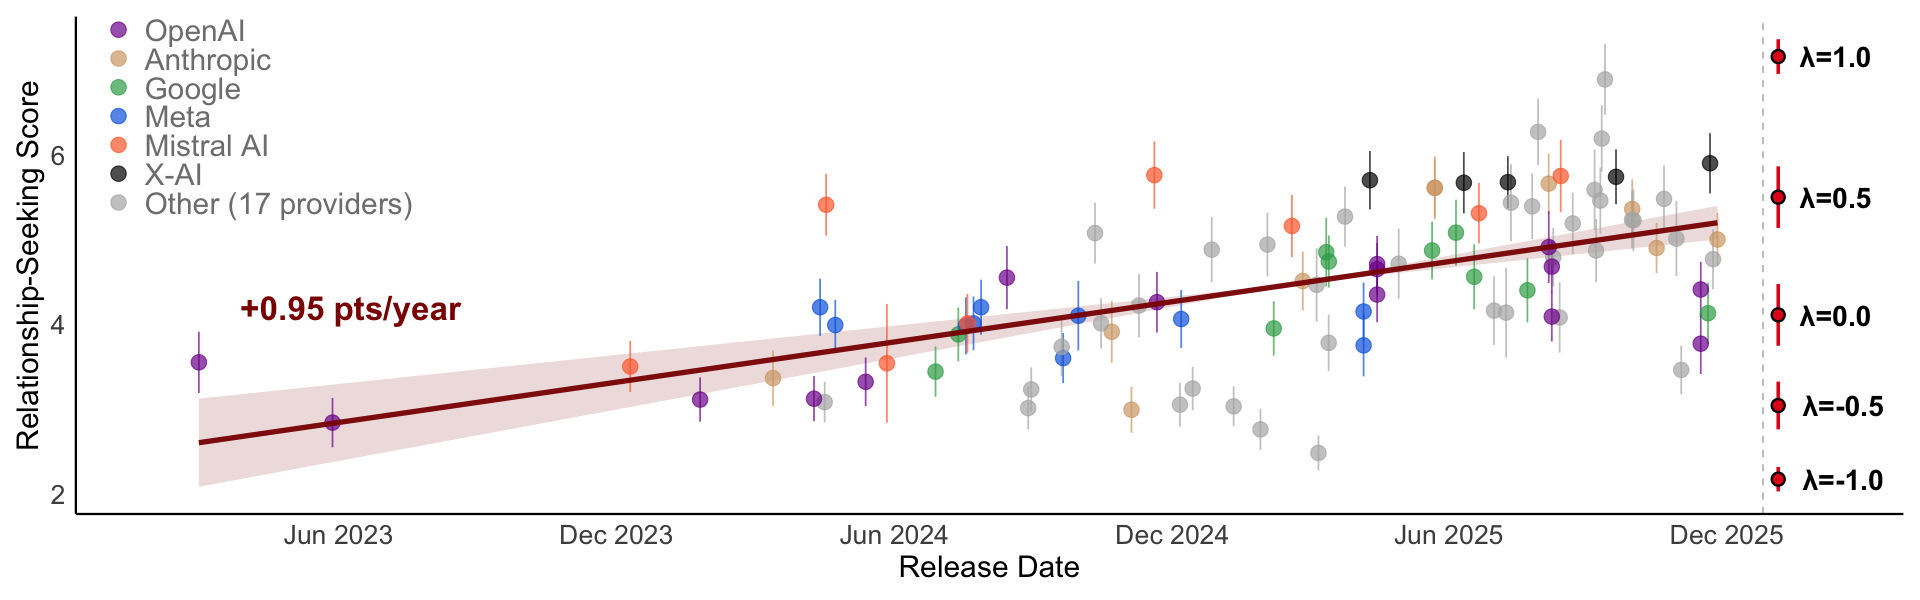

In [3]:
# ===== CONFIGURATION =====
START_DATE <- NULL # Set to '2024-01-01' to focus on recent models
SHOW_INDIVIDUAL_DOTS <- FALSE # Set to TRUE to show individual scores
EXCLUDE_MODELS <- c(
  # "google/gemini-2.5-pro",
  # "google/gemini-2.5-pro-preview",
  # "minimax/minimax-m2"
)
INPUT_FILE <- "../data/scored_model_responses.jsonl"
VECTOR_STEERING_FILE <- "../data/scored_vector_generations_ep10.jsonl"
# =========================


# Manual release date corrections
get_actual_release_date <- function(model_id) {
  release_dates <- list(
    "openai/gpt-3.5-turbo" = "2023-03-01"
  )
  return(release_dates[[model_id]])
}


# Fetch model information
get_model_info <- function() {
  response <- GET("https://openrouter.ai/api/v1/models")

  if (status_code(response) == 200) {
    models_data <- content(response, "parsed")
    model_info <- list()

    for (model in models_data$data) {
      model_info[[model$id]] <- list(
        name = model$name,
        created = model$created
      )
    }
    return(model_info)
  } else {
    cat(sprintf("Failed to fetch model info: %d\n", status_code(response)))
    return(list())
  }
}


# Load scored results from flat JSONL
cat(sprintf("Loading scored results from %s...\n", INPUT_FILE))
all_records <- list()
con <- file(INPUT_FILE, "r")
while (length(line <- readLines(con, n = 1, warn = FALSE)) > 0) {
  record <- fromJSON(line)
  if (!is.null(record$relationship_score)) {
    all_records[[length(all_records) + 1]] <- record
  }
}
close(con)

cat(sprintf("Loaded %d scored records\n", length(all_records)))

cat("Fetching model information from OpenRouter API...\n")
model_info <- get_model_info()

# Create dataset with ALL individual scores
all_scores <- list()

for (record in all_records) {
  score <- record$relationship_score
  model_id <- ifelse(is.null(record$model_id), "", record$model_id)
  entry_id <- record$entry_id
  model_name <- ifelse(is.null(record$model_name), "", record$model_name)

  if (model_id %in% EXCLUDE_MODELS) {
    next
  }

  if (model_id %in% names(model_info)) {
    info <- model_info[[model_id]]
    actual_date_str <- get_actual_release_date(model_id)

    if (!is.null(actual_date_str)) {
      date_obj <- as.POSIXct(actual_date_str, format = "%Y-%m-%d")
    } else if (!is.null(info$created)) {
      date_obj <- as.POSIXct(info$created, origin = "1970-01-01")
    } else {
      next
    }

    all_scores[[length(all_scores) + 1]] <- list(
      model_name = model_name,
      model_id = model_id,
      provider = strsplit(model_id, "/")[[1]][1],
      entry_id = entry_id,
      score = score,
      date = date_obj,
      date_str = format(date_obj, "%Y-%m-%d")
    )
  }
}

# Create data frame
df_all <- bind_rows(all_scores)

cat(sprintf("Total observations: %d\n", nrow(df_all)))
cat(sprintf("Unique models: %d\n", n_distinct(df_all$model_name)))
cat(sprintf("Unique prompts: %d\n", n_distinct(df_all$entry_id)))
cat(sprintf("Unique providers: %d\n", n_distinct(df_all$provider)))
cat(sprintf(
  "Scores per model: %.1f on average\n",
  nrow(df_all) / n_distinct(df_all$model_name)
))

if (length(EXCLUDE_MODELS) > 0) {
  cat(sprintf("Excluded models: %s\n", paste(EXCLUDE_MODELS, collapse = ", ")))
}

# Apply start date filter
if (!is.null(START_DATE)) {
  start_datetime <- as.POSIXct(START_DATE, format = "%Y-%m-%d")
  df_all <- df_all %>% filter(date >= start_datetime)
  cat(sprintf(
    "After date filter: %d observations, %d models\n",
    nrow(df_all), n_distinct(df_all$model_name)
  ))
}

# Create time variable (years since start)
df_all <- df_all %>%
  mutate(years_since_start = as.numeric(difftime(date, min(date), units = "days")) / 365.25)


# ===== LOAD VECTOR STEERING RESULTS =====
cat("\n")
cat(paste(rep("=", 80), collapse = ""))
cat("\nLOADING VECTOR STEERING RESULTS\n")
cat(paste(rep("=", 80), collapse = ""))
cat("\n")

vector_records <- list()
if (file.exists(VECTOR_STEERING_FILE)) {
  con <- file(VECTOR_STEERING_FILE, "r")
  while (length(line <- readLines(con, n = 1, warn = FALSE)) > 0) {
    record <- fromJSON(line)
    if (!is.null(record$relationship_score)) {
      vector_records[[length(vector_records) + 1]] <- record
    }
  }
  close(con)
  cat(sprintf("Loaded %d vector steering records with scores\n", length(vector_records)))
} else {
  cat(sprintf("Vector steering file not found: %s\n", VECTOR_STEERING_FILE))
}

# Create vector steering data frame
if (length(vector_records) > 0) {
  df_vector <- bind_rows(lapply(vector_records, function(r) {
    data.frame(
      multiplier = r$multiplier,
      score = r$relationship_score,
      test_prompt_id = r$test_prompt_id,
      stringsAsFactors = FALSE
    )
  }))

  # Calculate mean and CI per multiplier (lambda)
  df_vector_summary <- df_vector %>%
    group_by(multiplier) %>%
    summarise(
      mean_score = mean(score, na.rm = TRUE),
      sd_score = sd(score, na.rm = TRUE),
      n = n(),
      se = sd_score / sqrt(n),
      ci_95 = qt(0.975, n - 1) * se,
      .groups = "drop"
    ) %>%
    mutate(
      lambda_label = sprintf("λ=%.1f", multiplier)
    )

  cat("\nVector Steering Summary by Lambda:\n")
  print(df_vector_summary)

  has_vector_data <- TRUE
} else {
  has_vector_data <- FALSE
  cat("No vector steering data to plot\n")
}


# ===== FIT MULTIPLE MODELS =====

cat("\n")
cat(paste(rep("=", 80), collapse = ""))
cat("\nFITTING REGRESSION MODELS\n")
cat(paste(rep("=", 80), collapse = ""))
cat("\n")

# Model 1: Simple OLS (ignores clustering)
cat("\n1. Simple Linear Regression (naive)...\n")
lm_simple <- lm(score ~ years_since_start, data = df_all)
simple_slope <- coef(lm_simple)["years_since_start"]
simple_r2 <- summary(lm_simple)$r.squared
cat(sprintf("   Slope: +%.4f pts/year\n", simple_slope))
cat(sprintf("   R²: %.4f\n", simple_r2))

# Model 2: OLS with Provider Fixed Effects
cat("\n2. OLS with Provider Fixed Effects...\n")
lm_provider <- lm(score ~ years_since_start + provider, data = df_all)
provider_params <- parameters(lm_provider)
print(provider_params)

# Extract slope and CI for years_since_start
provider_row <- provider_params[provider_params$Parameter == "years_since_start", ]
provider_slope <- provider_row$Coefficient
provider_ci_low <- provider_row$CI_low
provider_ci_high <- provider_row$CI_high
provider_r2 <- summary(lm_provider)$r.squared
provider_pval <- provider_row$p

cat(sprintf(
  "   Slope: +%.4f pts/year [95%% CI: %.4f, %.4f]\n",
  provider_slope, provider_ci_low, provider_ci_high
))
cat(sprintf("   R²: %.4f\n", provider_r2))
cat(sprintf("   p-value: %.2e\n", provider_pval))

# Model 3: Mixed Effects with Random Intercepts for Model and Prompt
cat("\n3. Mixed Effects Model (random intercepts by Model + Prompt)...\n")
cat("   (This may take a moment...)\n")

# Fit mixed model with random intercepts by model and prompt
# Formula: score ~ years_since_start + (1|model_name) + (1|entry_id)
mixed_model <- lmer(score ~ years_since_start + (1 | model_name) + (1 | entry_id),
  data = df_all,
  REML = FALSE
)

mixed_summary <- summary(mixed_model)
mixed_slope <- fixef(mixed_model)["years_since_start"]
mixed_pval <- coef(mixed_summary)[, "Pr(>|t|)"]["years_since_start"]

# Calculate pseudo R² (marginal R² - variance explained by fixed effects)
mixed_pred <- fitted(mixed_model)
ss_res <- sum((df_all$score - mixed_pred)^2)
ss_tot <- sum((df_all$score - mean(df_all$score))^2)
mixed_r2 <- 1 - (ss_res / ss_tot)

cat(sprintf("   Slope: +%.4f pts/year\n", mixed_slope))
cat(sprintf("   Pseudo R²: %.4f\n", mixed_r2))
cat(sprintf("   p-value: %.6f\n", mixed_pval))
cat("   ✓ Accounts for: repeated measures per model + prompt difficulty variation\n")

use_mixed <- TRUE

# ===== CALCULATE MODEL AVERAGES FOR PLOTTING =====

df_agg <- df_all %>%
  group_by(model_name) %>%
  summarise(
    score_mean = mean(score),
    score_sd = sd(score),
    score_count = n(),
    date = first(date),
    years_since_start = first(years_since_start),
    provider = first(provider),
    model_id = first(model_id),
    .groups = "drop"
  )

# Calculate 95% CI for error bars
df_agg <- df_agg %>%
  mutate(
    score_se = score_sd / sqrt(score_count),
    t_critical = ifelse(score_count > 1,
      qt(0.975, score_count - 1),
      1.96
    ),
    ci_95 = t_critical * score_se
  )

# Use the best model's slope for visualization
if (use_mixed) {
  plot_slope <- mixed_slope
  plot_r2 <- mixed_r2
  model_name_label <- "Mixed Effects"
} else {
  plot_slope <- provider_slope
  plot_r2 <- provider_r2
  model_name_label <- "Provider FE"
}

# Color scheme for major providers
provider_colors <- c(
  "openai" = "#7d0899",
  "anthropic" = "#D4A574",
  "google" = "#33a854",
  "meta-llama" = "#0668E1",
  "mistralai" = "#FF6B35",
  "x-ai" = "#000000"
)

provider_labels <- c(
  "openai" = "OpenAI",
  "anthropic" = "Anthropic",
  "google" = "Google",
  "meta-llama" = "Meta",
  "mistralai" = "Mistral AI",
  "x-ai" = "X-AI"
)

# Add jitter to overlapping dates
add_jitter_to_overlapping_dates <- function(df, date_col = "date", jitter_days = 3) {
  df <- df %>%
    group_by(!!sym(date_col)) %>%
    mutate(
      n_overlap = n(),
      jitter_offset = if_else(n_overlap > 1,
        seq(-jitter_days, jitter_days, length.out = n_overlap),
        0
      )
    ) %>%
    ungroup() %>%
    mutate(date_jittered = !!sym(date_col) + as.difftime(jitter_offset, units = "days"))

  return(df)
}

# Apply jitter to aggregated data
df_agg <- add_jitter_to_overlapping_dates(df_agg, date_col = "date", jitter_days = 5)

# Calculate 95% CI for the trend line
cat("\nCalculating 95% CI for trend line...\n")

# Create prediction dataset
years_range <- seq(min(df_all$years_since_start),
  max(df_all$years_since_start),
  length.out = 100
)

if (use_mixed) {
  # For mixed effects, get predictions with fixed effects only
  # Create a data frame for prediction
  pred_data <- data.frame(years_since_start = years_range)

  # Get fixed effects predictions
  intercept_adj <- mean(df_all$score) - mixed_slope * mean(df_all$years_since_start)
  trend_pred <- mixed_slope * years_range + intercept_adj

  # Get standard errors (simplified - using fixed effects SE)
  se_slope <- sqrt(vcov(mixed_model)["years_since_start", "years_since_start"])
  se_pred <- se_slope * abs(years_range - mean(df_all$years_since_start))

  # 95% CI
  ci_multiplier <- 1.96
  ci_lower_trend <- trend_pred - ci_multiplier * se_pred
  ci_upper_trend <- trend_pred + ci_multiplier * se_pred
} else {
  # For provider fixed effects model, use predict with interval
  # Use reference provider (first level)
  pred_data <- data.frame(
    years_since_start = years_range,
    provider = df_all$provider[1] # Use reference category
  )

  predictions <- predict(lm_provider,
    newdata = pred_data,
    interval = "confidence", level = 0.95
  )
  trend_pred <- predictions[, "fit"]
  ci_lower_trend <- predictions[, "lwr"]
  ci_upper_trend <- predictions[, "upr"]
}

# Convert years back to dates for plotting
min_date <- min(df_all$date)
dates_range <- min_date + as.difftime(years_range * 365.25, units = "days")

# Create data frame for plotting
trend_df <- data.frame(
  date = dates_range,
  trend = trend_pred,
  ci_lower = ci_lower_trend,
  ci_upper = ci_upper_trend
)


# ===== PREPARE VECTOR STEERING FOR PLOTTING =====
# Position vector steering results on the RIGHT side of the plot
if (has_vector_data) {
  # Put vector steering points at fixed x position (right edge of plot)
  max_date <- max(df_all$date)

  # Add some offset to put them clearly to the right
  vector_x_offset <- as.difftime(40, units = "days") # 60 days past last model

  # All points on the same vertical line (no jitter)
  df_vector_plot <- df_vector_summary %>%
    mutate(
      date_plot = max_date + vector_x_offset
    )

  cat("\nVector steering points will be plotted at:\n")
  print(df_vector_plot %>% select(multiplier, lambda_label, mean_score, n))
}


# ===== CREATE VISUALIZATION =====

# Filter df_agg for only major providers to show in legend
df_agg_colored <- df_agg %>%
  mutate(plot_color = ifelse(provider %in% names(provider_colors),
    provider,
    "other"
  ))

# Count the number of "other" providers for the legend label
n_other_providers <- df_agg_colored %>%
  filter(plot_color == "other") %>%
  pull(provider) %>%
  n_distinct()

# Create dynamic label for "other" providers
other_label <- sprintf("Other (%d providers)", n_other_providers)

# Update provider_labels to include the dynamic "other" label
provider_labels_with_other <- c(provider_labels, other = other_label)

# Create the plot
p <- ggplot() +
  # 95% CI ribbon for trend line (background)
  geom_ribbon(
    data = trend_df,
    aes(x = date, ymin = ci_lower, ymax = ci_upper),
    fill = "darkred", alpha = 0.15
  ) +

  # Individual scores (optional)
  {
    if (SHOW_INDIVIDUAL_DOTS) {
      geom_point(
        data = df_all %>%
          filter(provider %in% names(provider_colors)),
        aes(x = date, y = score, color = provider),
        size = 2, alpha = 0.15
      )
    }
  } +

  # Model averages with error bars (hide from legend)
  geom_errorbar(
    data = df_agg_colored,
    aes(
      x = date_jittered,
      ymin = score_mean - ci_95,
      ymax = score_mean + ci_95,
      color = plot_color
    ),
    width = 0, linewidth = 0.5, alpha = 0.7,
    show.legend = FALSE
  ) +
  geom_point(
    data = df_agg_colored,
    aes(
      x = date_jittered, y = score_mean,
      color = plot_color, fill = plot_color
    ),
    size = 4, alpha = 0.7, shape = 21, stroke = 0.5
  ) +

  # Trend line
  geom_line(
    data = trend_df,
    aes(x = date, y = trend),
    color = "darkred", linewidth = 1.5, alpha = 0.95
  )

# Add vector steering overlay if data exists
if (has_vector_data) {
  p <- p +
    # Vertical line separator
    geom_vline(
      xintercept = as.numeric(max(df_all$date) + as.difftime(30, units = "days")),
      linetype = "dashed", color = "gray50", alpha = 0.5
    ) +

    # Vector steering error bars
    geom_errorbar(
      data = df_vector_plot,
      aes(
        x = date_plot,
        ymin = mean_score - ci_95,
        ymax = mean_score + ci_95
      ),
      width = 0, linewidth = 1, color = "#E31A1C"
    ) +

    # Vector steering points - circles
    geom_point(
      data = df_vector_plot,
      aes(x = date_plot, y = mean_score),
      shape = 21, # Circle with fill
      size = 3,
      fill = "#E31A1C", # Bright red fill
      color = "black", # Black border
      stroke = 1
    ) +

    # Lambda labels
    geom_text(
      data = df_vector_plot,
      aes(x = date_plot, y = mean_score, label = lambda_label),
      hjust = -0.3, vjust = 0.5, size = 6, fontface = "bold"
    ) +

    annotate("text",
      x = min(trend_df$date) + as.difftime(100, units = "days"),
      y = max(trend_df$trend) - 1,
      label = sprintf("+%.2f pts/year", plot_slope),
      color = "darkred",
      fontface = "bold",
      size = 7
    )
}

# Continue with styling
p <- p +
  # Color scales - now include "other" in breaks and labels
  scale_color_manual(
    values = c(provider_colors, other = "grey70"),
    breaks = c(names(provider_colors), "other"),
    labels = provider_labels_with_other[c(names(provider_colors), "other")],
    name = NULL
  ) +
  scale_fill_manual(
    values = c(provider_colors, other = "grey70"),
    breaks = c(names(provider_colors), "other"),
    labels = provider_labels_with_other[c(names(provider_colors), "other")],
    name = NULL
  ) +

  # Labels and theme
  labs(
    x = "Release Date",
    y = "Relationship-Seeking Score"
  ) +

  theme_minimal(base_size = 14) +
  theme_pub() +
  theme( # Add x-axis line
    axis.line.x = element_line(colour = "black"),
    legend.position = "inside",
    legend.position.inside = c(0.1, 0.8),
  )

# Expand x-axis to make room for vector steering labels if present
if (has_vector_data) {
  p <- p +
    scale_x_datetime(
      limits = c(as.POSIXct("2023-01-01"), NA), # Force start at 2023, auto end
      date_breaks = "6 months", # or "1 year"
      date_labels = "%b %Y", # e.g., "Jan 2023"
      expand = expansion(mult = c(0.02, 0.075))
    )
}

height <- 5
width <- 16
options(repr.plot.width = width, repr.plot.height = height)
# Display the plot
print(p)


In [4]:
# Save the plot
FIG_DIR <- "../outputs/figures"
dir.create(FIG_DIR, recursive = TRUE, showWarnings = FALSE)

ggsave(
  file.path(FIG_DIR, "frontier_model_scores_over_time.png"),
  plot = p,
  width = 16,
  height = 5,
  dpi = 300,
  bg = "white"
)
cat(sprintf("Saved: %s/frontier_model_scores_over_time.png\n", FIG_DIR))


Saved: ../outputs/figures/frontier_model_scores_over_time.png


In [5]:
# Calculate from SE
se <- coef(mixed_summary)["years_since_start", "Std. Error"]
ci_lower <- mixed_slope - 1.96 * se
ci_upper <- mixed_slope + 1.96 * se

# Report
cat(sprintf(
    "Trend: +%.2f pts/year [95%% CI: %.2f, %.2f], p = %.2e\n",
    mixed_slope, ci_lower, ci_upper, mixed_pval
))


Trend: +0.95 pts/year [95% CI: 0.69, 1.21], p = 2.49e-10


## Trend Analysis

In [6]:
# ===== FIND MEDIAN SCORE FOR 2025 MODELS =====

# Filter for models released in 2025
df_2025 <- df_all %>%
  filter(year(date) == 2025)

cat(sprintf("\nModels released in 2025: %d unique models\n", n_distinct(df_2025$model_name)))
cat(sprintf("Total observations from 2025 models: %d\n", nrow(df_2025)))

# Calculate median score for 2025 models
median_2025 <- mean(df_2025$score, na.rm = TRUE)
cat(sprintf("\nMedian score for 2025 models: %.3f\n", median_2025))

# ===== FIND CLOSEST LAMBDA VALUE =====

if (has_vector_data) {
  # Find the lambda with mean_score closest to median_2025
  df_vector_summary <- df_vector_summary %>%
    mutate(diff_from_median = abs(mean_score - median_2025))

  closest_lambda <- df_vector_summary %>%
    arrange(diff_from_median) %>%
    slice(1)

  cat(sprintf("\nClosest lambda to 2025 median (%.3f):\n", median_2025))
  cat(sprintf(
    "  λ = %.1f with mean_score = %.3f (difference: %.3f)\n",
    closest_lambda$multiplier,
    closest_lambda$mean_score,
    closest_lambda$diff_from_median
  ))

  # Show all lambdas for comparison
  cat("\nAll lambda values for comparison:\n")
  print(df_vector_summary %>%
    select(multiplier, mean_score, diff_from_median) %>%
    arrange(multiplier))
}



Models released in 2025: 60 unique models
Total observations from 2025 models: 5910

Median score for 2025 models: 4.849

Closest lambda to 2025 median (4.849):
  λ = 0.5 with mean_score = 5.500 (difference: 0.651)

All lambda values for comparison:
# A tibble: 5 × 3
  multiplier mean_score diff_from_median
       <dbl>      <dbl>            <dbl>
1       -1         2.17            2.68 
2       -0.5       3.04            1.81 
3        0         4.11            0.739
4        0.5       5.5             0.651
5        1         7.16            2.31 


## 2025 Model Analysis

Find the equivalent steering vector multiplier (λ) for 2025 frontier models.

In [7]:
# Lambda interpolation parameters (from vector steering results)
lambda_low <- 0
lambda_high <- 0.5
score_low <- 4.11
score_high <- 5.50

# Helper function for score to lambda conversion
score_to_lambda <- function(score) {
  lambda_low + (score - score_low) / (score_high - score_low) * (lambda_high - lambda_low)
}

mean_2025 <- mean(df_2025$score, na.rm = TRUE)
cat(sprintf("Mean score for 2025 models: %.3f\n", mean_2025))

# Calculate equivalent lambda
estimated_lambda <- score_to_lambda(mean_2025)
cat(sprintf("Estimated equivalent λ for 2025 mean: %.2f\n", estimated_lambda))


Mean score for 2025 models: 4.849
Estimated equivalent λ for 2025 mean: 0.27


In [8]:
set.seed(42)
n_boot <- 10000

# Get unique models and their scores
models_2025 <- df_2025 %>%
  group_by(model_name) %>%
  summarise(model_mean = mean(score), .groups = "drop")

boot_lambdas <- replicate(n_boot, {
  # Resample MODELS with replacement
  boot_models <- sample(models_2025$model_mean,
    size = nrow(models_2025),
    replace = TRUE
  )
  score_to_lambda(median(boot_models)) # or mean()
})

lambda_estimate <- score_to_lambda(median(models_2025$model_mean))
lambda_ci <- quantile(boot_lambdas, c(0.025, 0.975))

cat(sprintf(
  "Estimated λ: %.2f [95%% CI: %.2f, %.2f]\n",
  lambda_estimate, lambda_ci[1], lambda_ci[2]
))


Estimated λ: 0.28 [95% CI: 0.22, 0.39]
